<a href="https://colab.research.google.com/github/vedvkandge2000/ML-Projects-using-TF-and-Keras/blob/master/BtechProject22_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Import required dependancies for project.
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf

import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

!pip install mitdeeplearning
import mitdeeplearning as mdl

     |████████████████████████████████| 2.1 MB 5.5 MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.2.0-py3-none-any.whl size=2115442 sha256=c662fce91e6f3a453e58405d35fd94aae8c210a33fb77545c0bb5af60758cd0f
  Stored in directory: /root/.cache/pip/wheels/9a/b9/4f/99b7c8c5c75355550b83e1fcfc02956fb40c35eb01e2262877
Successfully built mitdeeplearning


In [ ]:
%cd '/content/drive/MyDrive/BTech_project/'

[Errno 2] No such file or directory: '/content/drive/MyDrive/BTech_project/'
/content


In [ ]:
# Import required Dataset:- Combination of both CelebA and ImageNet
train_data_path = './dataset/train_face.h5'

# Create instance of loader for dataset
DataLoader = mdl.lab2.TrainingDatasetLoader(train_data_path)

Opening ./dataset/train_face.h5
Loading data into memory...


In [ ]:
# Load training data
train_size = DataLoader.get_train_size()
(images, labels) = DataLoader.get_batch(100)

In [ ]:
train_size

109914

In [ ]:
# Train and test on standard classifier using basic CNN

# Architechture of encoder for Standard CNN and VAE
number_of_filters = 14 #base number of convolutional filters

def encoder(n_outputs=1):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([
    Conv2D(filters=1 * number_of_filters, kernel_size=6,  strides=2),
    BatchNormalization(),

    Conv2D(filters=2 * number_of_filters, kernel_size=6,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4 * number_of_filters, kernel_size=4,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6 * number_of_filters, kernel_size=4,  strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])
  return model

standard_classifier = encoder()

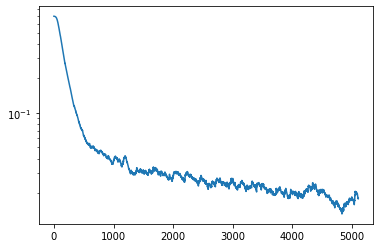

100%|██████████| 1717/1717 [00:26<00:00, 65.73it/s]


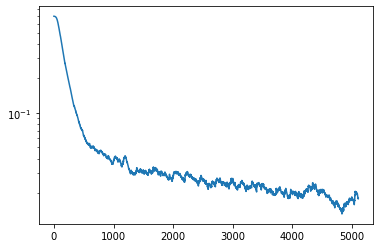

In [ ]:
# Training on standard classifier

# Hyperparameters for stadard classifier
batch_size = 64
num_epochs = 3
lr = 5e-5

optimizer = tf.keras.optimizers.Adam(lr)
loss_history = mdl.util.LossHistory(smoothing_factor=0.99)
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear()

@tf.function
def standard_train_step(x, y):
  with tf.GradientTape() as tape:

    logits = standard_classifier(x)

    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)


  grads = tape.gradient(loss, standard_classifier.trainable_variables)
  optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables))
  return loss

for epoch in range(num_epochs):
  for idx in tqdm(range(DataLoader.get_train_size()//batch_size)):

    x, y = DataLoader.get_batch(batch_size)
    loss = standard_train_step(x, y)

    loss_history.append(loss.numpy().mean())
    plotter.plot(loss_history.get())

In [ ]:
# Calculate accuracy for standard classifier
(batch_x, batch_y) = DataLoader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))

print("Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(acc_standard.numpy()))

Standard CNN accuracy on (potentially biased) training set: 0.9952


In [ ]:
# Load test data
test_faces = mdl.lab2.get_test_faces()
keys = ["Light Female", "Light Male", "Dark Female", "Dark Male"]

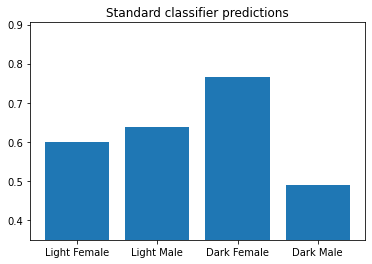

In [ ]:
# calculate accuracy across four different demographics
standard_classifier_logits = [standard_classifier(np.array(x, dtype=np.float32)) for x in test_faces]
standard_classifier_probs = tf.squeeze(tf.sigmoid(standard_classifier_logits))

xx = range(len(keys))
yy = standard_classifier_probs.numpy().mean(1)
plt.bar(xx, yy)
plt.xticks(xx, keys)
plt.ylim(max(0,yy.min()-yy.ptp()/2.), yy.max()+yy.ptp()/2.)
plt.title("Standard classifier predictions");

In [ ]:
# Train and test on Variational autoencoder

# loss function for VAE
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
  latent_loss = 0.5 * tf.reduce_sum((tf.exp(logsigma) + tf.square(mu) - 1 - logsigma), axis=1)
  reconstruction_loss = tf.reduce_mean(tf.abs(x - x_recon), axis=(1,2,3))
  vae_loss = kl_weight * latent_loss + reconstruction_loss
  return vae_loss

In [ ]:
# function of reparameterize for VAE
def sampling(z_mean, z_logsigma):
  batch, latent_dim = z_mean.shape
  epsilon = tf.random.normal(shape=(batch, latent_dim))
  z = z_mean + tf.exp(0.5 * z_logsigma) * epsilon
  return z

In [ ]:
# function calculate classifcation loss and total loss using VAE loss
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):
  vae_loss = vae_loss_function(x, x_pred, mu, logsigma)
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(y, y_logit)
  face_indicator = tf.cast(tf.equal(y, 1), tf.float32)
  total_loss = classification_loss + face_indicator * vae_loss
  return total_loss, classification_loss

In [ ]:
# Architechture of decoder for VAE

n_filters = 14
latent_dim = 100
def decoder():
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape

  decoder = tf.keras.Sequential([
    # Transform to pre-convolutional generation
    Dense(units=4*4*6*n_filters),  # 4x4 feature maps (with 6N occurances)
    Reshape(target_shape=(4, 4, 6*n_filters)),

    # Upscaling convolutions (inverse of encoder)
    Conv2DTranspose(filters=4*n_filters, kernel_size=4,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=4,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=6,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=6,  strides=2),
  ])
  return decoder

In [ ]:
# Architechture of VAE using encoder and decoder

class VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(VAE, self).__init__()
    self.latent_dim = latent_dim

    # Define the number of outputs for the encoder.
    num_encoder_dims = 2*self.latent_dim + 1

    self.encoder = encoder(num_encoder_dims)
    self.decoder = decoder()


  def encode(self, x):
    encoder_output = self.encoder(x)
    print(encoder_output.shape)
    # classification prediction
    y_logit = tf.expand_dims(encoder_output[:, 0], -1)
    print(y_logit.shape, y_logit)
    # latent variable distribution parameters
    z_mean = encoder_output[:, 1:self.latent_dim+1]
    z_logsigma = encoder_output[:, self.latent_dim+1:]

    return y_logit, z_mean, z_logsigma

  # VAE reparameterization: given a mean and logsigma, sample latent variables
  def reparameterize(self, z_mean, z_logsigma):
    z = sampling(z_mean, z_logsigma)
    return z

  # Decode the latent space and output reconstruction
  def decode(self, z):
    reconstruction = self.decoder(z)
    return reconstruction

  # The call function will be used to pass inputs x through the core VAE
  def call(self, x):
    # Encode input to a prediction and latent space
    y_logit, z_mean, z_logsigma = self.encode(x)
    z = self.reparameterize(z_mean, z_logsigma)
    recon = self.decode(z)
    return y_logit, z_mean, z_logsigma, recon

  # Predict face or not face logit for given input x
  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    return y_logit

model = VAE(latent_dim)

In [ ]:
def get_latent_mu(images, dbvae, batch_size=1024):
  N = images.shape[0]
  mu = np.zeros((N, latent_dim))
  for start_ind in range(0, N, batch_size):
    end_ind = min(start_ind+batch_size, N+1)
    batch = (images[start_ind:end_ind]).astype(np.float32)/255.
    _, batch_mu, _ = dbvae.encode(batch)
    mu[start_ind:end_ind] = batch_mu
  return mu

In [ ]:
def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=0.001):
    print("Recomputing the sampling probabilities")

    mu = get_latent_mu(images, dbvae)

    # sampling probabilities for the images
    training_sample_p = np.zeros(mu.shape[0])

    # consider the distribution for each latent variable
    for i in range(latent_dim):

        latent_distribution = mu[:,i]
        # generate a histogram of the latent distribution
        hist_density, bin_edges =  np.histogram(latent_distribution, density=True, bins=bins)

        # find which latent bin every data sample falls in
        bin_edges[0] = -float('inf')
        bin_edges[-1] = float('inf')

        bin_idx = np.digitize(latent_distribution, bin_edges)

        # smooth the density function
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)

        # invert the density function
        p = 1.0/(hist_smoothed_density[bin_idx-1])
        p = p / np.sum(p)

        training_sample_p = np.maximum(p, training_sample_p)

    # final normalization
    training_sample_p /= np.sum(training_sample_p)

    return training_sample_p

In [ ]:
batch_size = 64
lr = 5e-5
latent_dim = 100

# VAE needs slightly more epochs to train since its more complex than
# the standard classifier so we use 6 instead of 2
num_epochs = 6

# instantiate a new VAE model and optimizer
dbvae = VAE(100)
optimizer = tf.keras.optimizers.Adam(lr)

# To define the training operation, we will use tf.function which is a powerful tool
#   that lets us turn a Python function into a TensorFlow computation graph.
@tf.function
def debiasing_train_step(x, y):

  with tf.GradientTape() as tape:
    # Feed input x into dbvae. Note that this is using the VAE call function!
    y_logit, z_mean, z_logsigma, x_recon = dbvae(x)

    loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)

  grads = tape.gradient(loss, dbvae.trainable_variables)

  # apply gradients to variables
  optimizer.apply_gradients(zip(grads, dbvae.trainable_variables))
  return loss

# get training faces from data loader
data = DataLoader.get_all_train_faces()

In [ ]:
# class MyHyperModel(kt.HyperModel):
#   def build(self, latent_dim):
#     model = VAE(latent_dim)

In [ ]:
checkpoint_path = "./checkpoints2/train"
ckpt = tf.train.Checkpoint(model=dbvae,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

Starting epoch 6/6
Recomputing the sampling probabilities
(1024, 201)
(1024, 1) tf.Tensor(
[[0.8908837]
 [7.4543896]
 [5.381349 ]
 ...
 [2.0106525]
 [1.7195266]
 [1.7699729]], shape=(1024, 1), dtype=float32)
(1024, 201)
(1024, 1) tf.Tensor(
[[ 2.8055277]
 [12.2177725]
 [ 9.172564 ]
 ...
 [ 1.4984226]
 [ 2.7120137]
 [ 7.9547825]], shape=(1024, 1), dtype=float32)
(1024, 201)
(1024, 1) tf.Tensor(
[[8.285665  ]
 [2.575462  ]
 [0.53726393]
 ...
 [1.3499718 ]
 [6.9613175 ]
 [3.1048534 ]], shape=(1024, 1), dtype=float32)
(1024, 201)
(1024, 1) tf.Tensor(
[[13.360592  ]
 [ 3.8554559 ]
 [ 3.8840754 ]
 ...
 [-0.0298805 ]
 [ 1.2046422 ]
 [-0.17901166]], shape=(1024, 1), dtype=float32)
(1024, 201)
(1024, 1) tf.Tensor(
[[ 0.65703565]
 [ 5.098862  ]
 [-0.965305  ]
 ...
 [ 1.8132336 ]
 [ 3.005001  ]
 [11.213708  ]], shape=(1024, 1), dtype=float32)
(1024, 201)
(1024, 1) tf.Tensor(
[[ 5.487622 ]
 [11.502798 ]
 [ 2.2572656]
 ...
 [10.315539 ]
 [ 5.119096 ]
 [ 2.8461018]], shape=(1024, 1), dtype=float32)


  0%|          | 0/1717 [00:00<?, ?it/s]

(64, 201)
(64, 1) tf.Tensor(
[[ -9.25256  ]
 [ -5.94298  ]
 [ -7.5625715]
 [-16.493988 ]
 [-11.165196 ]
 [ -6.7727594]
 [-10.317514 ]
 [-10.312253 ]
 [-17.872656 ]
 [-10.460056 ]
 [ -8.8315   ]
 [ -9.95589  ]
 [-14.565808 ]
 [-16.112047 ]
 [-10.398993 ]
 [-10.366794 ]
 [ -8.94606  ]
 [ -7.2305183]
 [ -6.6379147]
 [ -8.465566 ]
 [-10.558042 ]
 [-16.68985  ]
 [-20.871021 ]
 [ -9.572507 ]
 [-11.655974 ]
 [-13.566197 ]
 [ -6.874343 ]
 [ -9.151832 ]
 [-11.021534 ]
 [-18.800545 ]
 [ -7.635825 ]
 [ -6.344351 ]
 [ 15.303138 ]
 [ 12.560041 ]
 [  3.2934353]
 [ 17.003494 ]
 [ 16.666294 ]
 [ 15.83739  ]
 [ 17.722391 ]
 [ 13.652617 ]
 [  9.891271 ]
 [ 19.553402 ]
 [  7.186054 ]
 [  5.3919687]
 [ 18.432098 ]
 [ 14.298284 ]
 [ 13.805169 ]
 [ 13.154498 ]
 [  9.902053 ]
 [ 10.150359 ]
 [ 14.157207 ]
 [  9.994206 ]
 [ 11.696499 ]
 [ 15.181703 ]
 [  6.9048944]
 [ 10.107419 ]
 [  9.805756 ]
 [ 13.4154415]
 [  4.8414164]
 [ 17.47581  ]
 [  8.0756445]
 [  7.5877733]
 [ 14.913727 ]
 [ 15.945874 ]], shape=(64

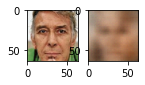

 29%|██▉       | 494/1717 [00:06<00:16, 74.21it/s]

(64, 201)
(64, 1) tf.Tensor(
[[ -9.044508  ]
 [-10.96282   ]
 [-14.156145  ]
 [-10.18264   ]
 [-15.488647  ]
 [ -6.2947    ]
 [-12.716438  ]
 [-11.468343  ]
 [-12.979925  ]
 [ -8.911728  ]
 [ -5.2340164 ]
 [ -9.204988  ]
 [ -7.640833  ]
 [ -5.3388505 ]
 [-21.42647   ]
 [-11.722264  ]
 [ -0.96883804]
 [ -5.9597363 ]
 [-12.02238   ]
 [ -5.476964  ]
 [ -7.9307747 ]
 [ -2.7569923 ]
 [ -4.568139  ]
 [ -8.934073  ]
 [-13.298154  ]
 [ -7.1323204 ]
 [-22.100153  ]
 [-13.793975  ]
 [ -5.4884644 ]
 [ -8.998862  ]
 [-14.539975  ]
 [ -1.8467611 ]
 [ 20.896513  ]
 [ 20.183199  ]
 [ 23.546995  ]
 [ 18.466604  ]
 [ 15.104009  ]
 [ 19.319483  ]
 [ 15.754048  ]
 [ 15.247026  ]
 [ 20.551033  ]
 [ 14.958833  ]
 [ 16.001953  ]
 [ 19.419256  ]
 [  6.3397264 ]
 [  5.760791  ]
 [ 14.445431  ]
 [ 13.919786  ]
 [ 17.118542  ]
 [ 10.5986805 ]
 [ 10.437855  ]
 [ 17.911642  ]
 [ 14.224429  ]
 [ 14.990408  ]
 [  9.804651  ]
 [  6.0207996 ]
 [ 10.2849455 ]
 [ 14.143984  ]
 [ 18.89012   ]
 [ 10.292196  ]
 [ 16.25649

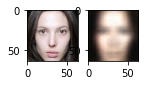

 58%|█████▊    | 998/1717 [00:13<00:09, 76.04it/s]

(64, 201)
(64, 1) tf.Tensor(
[[-13.485781 ]
 [ -9.845481 ]
 [ -7.610387 ]
 [-16.269827 ]
 [-12.647322 ]
 [ -7.6655164]
 [-10.076352 ]
 [ -3.0530362]
 [ -5.924799 ]
 [-12.477242 ]
 [ -4.591525 ]
 [-11.404742 ]
 [ -4.8172865]
 [ -9.811428 ]
 [-10.161107 ]
 [-15.542499 ]
 [-12.654819 ]
 [ -7.9908223]
 [ -4.285951 ]
 [-10.2773485]
 [ -5.1277266]
 [-10.463509 ]
 [ -8.240081 ]
 [-12.115481 ]
 [ -5.681451 ]
 [ -6.5404415]
 [ -7.799201 ]
 [-11.937234 ]
 [ -6.7429066]
 [ -6.3523893]
 [ -5.728801 ]
 [ -8.198334 ]
 [  4.271558 ]
 [ 17.69536  ]
 [ 13.756705 ]
 [ 12.707564 ]
 [ 10.092339 ]
 [ 11.942726 ]
 [  8.379502 ]
 [ 11.049388 ]
 [ 12.825124 ]
 [ 19.440298 ]
 [ 14.957857 ]
 [ 14.464084 ]
 [ 11.497617 ]
 [ 18.405233 ]
 [  6.6442914]
 [ 13.667027 ]
 [  8.7862835]
 [ 15.179648 ]
 [ 13.405413 ]
 [ 15.935043 ]
 [ 16.769093 ]
 [  7.1708236]
 [ 18.03021  ]
 [ 16.571777 ]
 [ 19.791628 ]
 [  5.415315 ]
 [ 15.023306 ]
 [  8.841322 ]
 [ 20.04145  ]
 [ 18.621016 ]
 [ 14.065326 ]
 [ 20.660185 ]], shape=(64

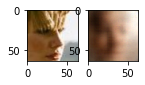

 87%|████████▋ | 1494/1717 [00:20<00:02, 76.24it/s]

(64, 201)
(64, 1) tf.Tensor(
[[ -5.6271305]
 [-12.389009 ]
 [ -9.125283 ]
 [-12.024601 ]
 [-10.857034 ]
 [ -4.4173756]
 [ -1.6151385]
 [-13.598689 ]
 [ -8.964893 ]
 [ -8.822953 ]
 [ -8.282502 ]
 [-12.34298  ]
 [-16.091349 ]
 [-12.33244  ]
 [ -7.278055 ]
 [-10.059922 ]
 [-11.658427 ]
 [-12.763027 ]
 [-20.10553  ]
 [ -6.9298525]
 [-16.14598  ]
 [-15.276788 ]
 [-10.762841 ]
 [  0.7522413]
 [-13.651729 ]
 [-10.432298 ]
 [-16.336227 ]
 [ -9.253028 ]
 [ -9.268047 ]
 [ -9.131161 ]
 [-12.436065 ]
 [-11.733825 ]
 [ 14.224053 ]
 [ 24.361074 ]
 [ 11.694055 ]
 [  1.3703096]
 [ 18.844833 ]
 [ 16.20955  ]
 [ 11.606015 ]
 [ 20.997908 ]
 [  5.678771 ]
 [  8.292952 ]
 [ 15.993302 ]
 [ 12.274896 ]
 [ 16.38033  ]
 [ 13.1349   ]
 [  9.586434 ]
 [  5.763261 ]
 [ 18.715403 ]
 [ 13.528858 ]
 [ 16.272028 ]
 [  9.425555 ]
 [ 13.832504 ]
 [ 11.463164 ]
 [ 21.47576  ]
 [ 18.840422 ]
 [ 16.261763 ]
 [ 11.473906 ]
 [  7.8106327]
 [ 19.655375 ]
 [ 17.724247 ]
 [ 14.736172 ]
 [ 21.695118 ]
 [ 16.293766 ]], shape=(64

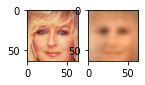

100%|██████████| 1717/1717 [00:23<00:00, 71.58it/s]


In [ ]:
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

# The training loop -- outer loop iterates over the number of epochs
for i in range(start_epoch, num_epochs):

  IPython.display.clear_output(wait=True)
  print("Starting epoch {}/{}".format(i+1, num_epochs))

  # Recompute data sampling proabilities
  p_faces = get_training_sample_probabilities(data, dbvae)

  # get a batch of training data and compute the training step
  for j in tqdm(range(DataLoader.get_train_size() // batch_size)):
    # load a batch of data
    (x, y) = DataLoader.get_batch(batch_size, p_pos=p_faces)
    # loss optimization
    loss = debiasing_train_step(x, y)

    # plot the progress every 200 steps
    if j % 500 == 0:
      mdl.util.plot_sample(x, y, dbvae)

  if i % 5 == 0:
      ckpt_manager.save()

(5, 201)
(5, 1) tf.Tensor(
[[15.656201 ]
 [-1.2192973]
 [-6.199366 ]
 [15.133511 ]
 [13.91377  ]], shape=(5, 1), dtype=float32)
(5, 201)
(5, 1) tf.Tensor(
[[16.983728 ]
 [ 1.4244611]
 [-8.871222 ]
 [12.426595 ]
 [10.730895 ]], shape=(5, 1), dtype=float32)
(5, 201)
(5, 1) tf.Tensor(
[[11.266967  ]
 [ 6.429446  ]
 [ 0.8261578 ]
 [ 4.37557   ]
 [ 0.02353548]], shape=(5, 1), dtype=float32)
(5, 201)
(5, 1) tf.Tensor(
[[-1.3919519]
 [ 5.082231 ]
 [-4.214969 ]
 [ 4.4629703]
 [ 3.1892457]], shape=(5, 1), dtype=float32)


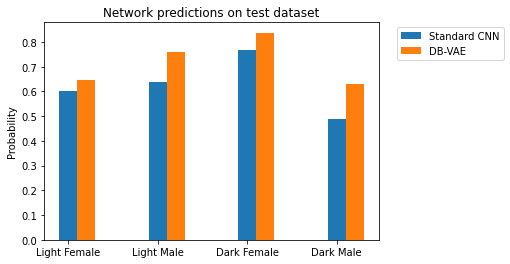

In [ ]:
dbvae_logits = [dbvae.predict(np.array(x, dtype=np.float32)) for x in test_faces]
dbvae_probs = tf.squeeze(tf.sigmoid(dbvae_logits))

xx = np.arange(len(keys))
plt.bar(xx, standard_classifier_probs.numpy().mean(1), width=0.2, label="Standard CNN")
plt.bar(xx+0.2, dbvae_probs.numpy().mean(1), width=0.2, label="DB-VAE")
plt.xticks(xx, keys);
plt.title("Network predictions on test dataset")
plt.ylabel("Probability"); plt.legend(bbox_to_anchor=(1.04,1), loc="upper left");